# Exercises for 2021-03-18

In [35]:
using LinearAlgebra
using Plots

## Non-negative matrix factorization

Consider the problem of finding the best rank 3 NMF approximation of the following 10-by-5 data matrix.

In [36]:
A = [0 0 0 1 0;
     0 0 0 0 1;
     0 0 0 0 1;
     1 0 1 0 0;
     1 0 0 0 0;
     0 1 0 0 0;
     1 0 1 1 0;
     0 1 1 0 0;
     0 0 1 1 1;
     0 1 1 0 0]

10×5 Array{Int64,2}:
 0  0  0  1  0
 0  0  0  0  1
 0  0  0  0  1
 1  0  1  0  0
 1  0  0  0  0
 0  1  0  0  0
 1  0  1  1  0
 0  1  1  0  0
 0  0  1  1  1
 0  1  1  0  0

Most of the methods we have for NMF are iterative (unless some separability condition is satisfied), which means we need an initial guess.
We use an SVD-based initial guess due to Boutsidis and Gallapoulos ([2007 paper](http://scgroup.hpclab.ceid.upatras.gr/faculty/stratis/Papers/HPCLAB020107.pdf)).

In [37]:
function svd_nmf_init(A, k)
    U, σs, V = svd(A)
    W = zeros(size(A)[1], k)
    H = zeros(k, size(A)[2])
    for j = 1:k
        xp = max.( U[:,j], 0.0)
        xn = max.(-U[:,j], 0.0)
        yp = max.( V[:,j], 0.0)
        yn = max.(-V[:,j], 0.0)
        norm_xp = norm(xp)
        norm_xn = norm(xn)
        norm_yp = norm(yp)
        norm_yn = norm(yn)
        norms_p = norm_xp * norm_yp
        norms_n = norm_xn * norm_yn
        if norms_p > norms_n
            scale = sqrt(σs[j] * norms_p)
            W[:,j] = (scale/norm_xp) * xp
            H[j,:] = (scale/norm_xp) * yp
        else
            scale = sqrt(σs[j] * norms_n)
            W[:,j] = (scale/norm_xn) * xn
            H[j,:] = (scale/norm_yn) * yn
        end
    end
    return W, H
end

svd_nmf_init (generic function with 1 method)

### Projective gradient

We will start with the simple projective gradient iteration from the class notes.

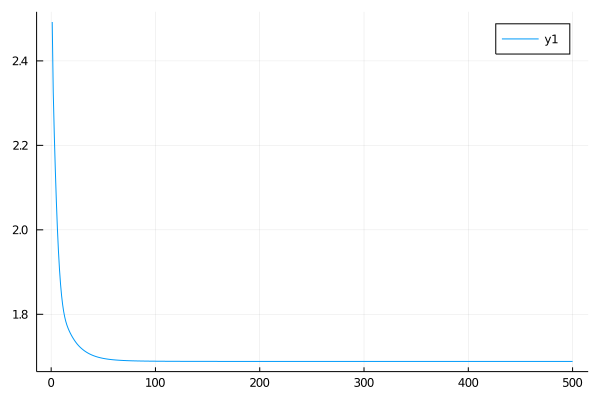

In [38]:
α = 0.1
W, H = svd_nmf_init(A, 3)
resids = zeros(500)
for k = 1:500
    R = A-W*H
    resids[k] = norm(R)
    Wnew = max.(W + α*R*H', 0.0)
    Hnew = max.(H + α*W'*R, 0.0)
    W, H = Wnew, Hnew
end
plot(resids)

In [39]:
W

10×3 Array{Float64,2}:
 0.266833  0.0       0.162798
 0.0       0.0       0.696968
 0.0       0.0       0.696968
 0.780823  0.121595  0.0
 0.431757  0.0       0.0
 0.0       0.543525  0.0
 1.11285   0.0       0.0503089
 0.063096  0.940844  0.000959324
 0.447041  0.175661  0.903486
 0.063096  0.940844  0.000959324

In [40]:
H

3×5 Array{Float64,2}:
 1.00514  0.0      0.911369  0.697932  0.0
 0.0      1.14861  0.891042  0.0       0.0
 0.0      0.0      0.194767  0.421174  1.26451

In [41]:
resids[end]

1.6884158127130842

### Lee and Seung

The Lee and Seung iteration takes a while to converge, as we can see from a plot of the residual norm.

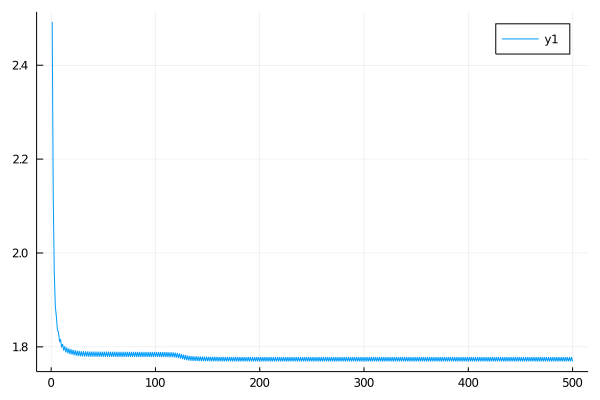

In [42]:
W, H = svd_nmf_init(A, 3)
resids = zeros(500)
for k = 1:500
    resids[k] = norm(A-W*H)
    Wnew = W ./ (W*H*H') .* (A*H')
    Hnew = H ./ (W'*W*H) .* (W'*A)
    W, H = Wnew, Hnew
end
plot(resids)

In [43]:
W

10×3 Array{Float64,2}:
 0.372675  0.0       0.0
 0.0       0.0       0.832396
 0.0       0.0       0.832396
 0.73881   0.140745  0.0
 0.372797  0.0       0.0
 0.0       0.604869  0.0
 1.15703   0.0       0.0
 0.084646  1.01026   0.0
 0.738189  0.0       0.861594
 0.084646  1.01026   0.0

In [44]:
H

3×5 Array{Float64,2}:
 0.926158  1.8412e-116  1.02245   0.925855  5.40737e-7
 0.0       1.20197      0.873622  0.0       0.0
 0.0       0.0          0.144272  0.0       1.31905

In [45]:
A-W*H

10×5 Array{Float64,2}:
 -0.345156   -6.86169e-117  -0.381042   0.654957  -2.01519e-7
  0.0         0.0           -0.120091   0.0       -0.097973
  0.0         0.0           -0.120091   0.0       -0.097973
  0.315745   -0.169171       0.121646  -0.684031  -3.99502e-7
  0.654731   -6.86394e-117  -0.381167  -0.345156  -2.01585e-7
  0.0         0.272965      -0.528427   0.0        0.0
 -0.0715917  -2.13032e-116  -0.183005  -0.071241  -6.25649e-7
 -0.0783956  -0.214302       0.03087   -0.07837   -4.57713e-8
 -0.68368    -1.35915e-116   0.120934   0.316544  -0.136488
 -0.0783956  -0.214302       0.03087   -0.07837   -4.57713e-8

In [46]:
resids[end]

1.768958963443623

## TODO
### HALS/RRI (3 points)

Your job is to implement the HALS iteration (also known as RRI), as described in the class notes.  As with the other iterations, show a plot of the residual, and print the final $W$ and $H$ factors.  Do they look similar to the factors computed by either of the previous methods?

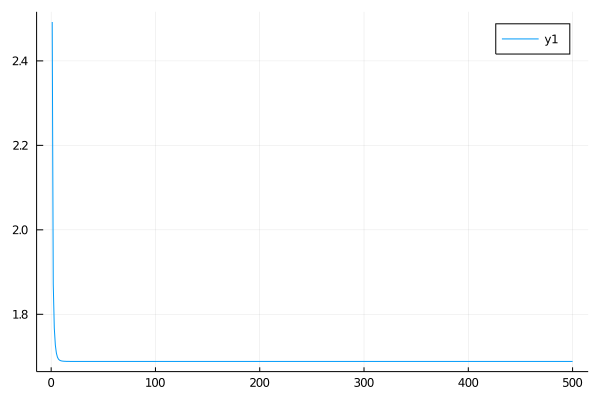

In [47]:
W, H = svd_nmf_init(A, 3)
resids = zeros(500)
u = zeros(10)
v = zeros(5)
function Hals(A, B, C) 
    for i = 1:3 
        den = C'*C
        num1 = C'*A 
        num2 = C'*C*B
        up   = max.(-B[i,:], (num1[i,:]-num2[i,:])/(den[i,i]))
        B[i,:] = B[i,:] + up
    end
    return B
end
for k = 1:500 
    resids[k] = norm(A-W*H)
    W         = Hals(A',W',H')
    W         = W'
    H         = Hals(A,H,W)
end
plot(resids)

In [48]:
W

10×3 Array{Float64,2}:
 0.237099   0.0       0.173819
 0.0        0.0       0.743881
 0.0        0.0       0.743881
 0.693948   0.132985  0.0
 0.383728   0.0       0.0
 0.0        0.594464  0.0
 0.988993   0.0       0.0537325
 0.0560712  1.02903   0.00102502
 0.397226   0.19214   0.964382
 0.0560712  1.02903   0.00102502

In [49]:
H

3×5 Array{Float64,2}:
 1.13105  0.0      1.02548   0.785262  0.0
 0.0      1.05018  0.814691  0.0       0.0
 0.0      0.0      0.182511  0.394683  1.1847

### Alternating least squares

#### The NNLS building block

The alternating least squares approach for non-negative matrix factorization requires solving a series of non-negative least squares problem.
For this, it's useful to have a reasonable non-negative least squares problem.  We include below an active set solver for minimizing $\|Ax-b\|^2$ subject to elementwise non-negativity constraints on $A$, essentially identical to the method proposed by [Bro and De Jong](https://analyticalsciencejournals.onlinelibrary.wiley.com/doi/abs/10.1002/%28SICI%291099-128X%28199709/10%2911%3A5%3C393%3A%3AAID-CEM483%3E3.0.CO%3B2-L).

This could be made faster by being a little smarter about the linear algebra at each step, and could potentially be a little more stable by not explicitly forming $A^T A$ and $A^T b$ directly (and instead using the QR factorization).

In [50]:
function nnls(AtA, Atb, x = [])

  # Set up LS problem
  (m,n) = size(AtA)

  # Set up starting point and tolerance
  if isempty(x)
    x = AtA\Atb
  end
  x = max.(x, 0.0)
  tol = 100*eps(eltype(Atb))
  maxiter = 1000

  # Allocate storage for step, residual, gradient/multipliers
  p = zeros(n)
  r = zeros(n)
  rr = zeros(n)

  # Set initial passive set
  P = vec(x .> 0.0)

  # Main loop
  for i = 1:maxiter

    # Constrained Newton direction
    fill!(p,0.)
    rr[:] = AtA*x-Atb
    p[P] = AtA[P,P]\rr[P]

    if norm(p, Inf) < tol

      # Find constraint that should not be active (most negative multiplier)
      m = 0
      rrmin = 0.
      for j = 1:n
        if !P[j] && rr[j] < rrmin
          rrmin = rr[j]
          m = j
        end
      end

      # Release constraint or return
      if rrmin < 0.
        P[m] = true
      else
        return x
      end

    else

      # Determine step length
      alpha = 1.
      m = 0
      for j = 1:n
        if p[j] > 0. && x[j] < alpha*p[j]
          m = j
          alpha = min(alpha, x[j]/p[j])
        end
      end
      
      # Take a Newton step and adjust P
      if alpha == 1.
        x[:] -= p
      else
        x[:] -= alpha*p
        P[m] = false
      end
      x[:] = max.(x, 0.)

    end

  end  
  println("Did not converge")
  x
end

nnls (generic function with 2 methods)

In [51]:
Atest = rand(10,3)
btest = Atest * [1.0 1.0 -1.0]'
xtest = nnls(Atest'*Atest, Atest'*btest)
rtest = Atest'*(Atest*xtest-btest)
println("x = $xtest")
println("r = $rtest")

x = [0.6118834124376464; 0.3535512158435621; 0.0]
r = [-8.377221642379851e-16; 3.1868727969531476e-16; 1.156436486459188]


## TODO
#### The alternating least squares algorithm (3 points)

Per our discussion in class, one step of alternating least squares for NMF involves two pieces:

1. Assuming $W$ is correct, solve a series of non-negative least squares problems (one per column of $H$ or $A$) to fill in $H$.
2. Assuming $H$ is correct, solve a series of non-negative least squares problems (one per row of $W$ or $A$) to fill in $W$.

Implement this ALS iteration, and again plot convergence.  Note that using the previous iterate for starting guesses for the columns of $H$ or rows of $W$ will probably speed up the NNLS solver.

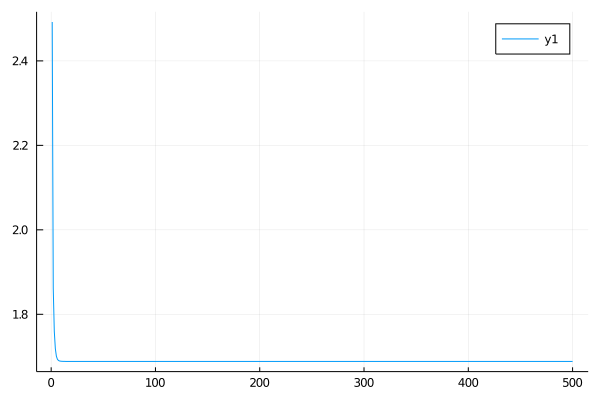

In [61]:
W, H = svd_nmf_init(A, 3)
resids = zeros(500)
h = []
w = []
function ALAstep(A,x,B,szx)
    num_rows = (size(A))[2]
    X = zeros(num_rows,szx)
    for i = 1:szx
        b = B[:,i]
        X[:,i] = nnls(A'A,A'b,x)
    end
    return X
end
for k = 1:500 
    resids[k] = norm(A-W*H)
    H = ALAstep(W,h,A,5)
    W = ALAstep(H',w,A',10)
    W = W'
end
plot(resids)

## Tensor manipulations and the higher-order SVD (HOSVD)

We can represent a dense order 3 tensor in Julia as a simple three-way array.  Let's create a simple example with a known CP decomposition.

In [19]:
F = rand(10,3)
G = rand(10,3)
H = rand(10,3)
A = [sum(F[i,:].*G[j,:].*H[k,:]) for i=1:10, j=1:10, k=1:10]

10×10×10 Array{Float64,3}:
[:, :, 1] =
 0.536623  0.225961  0.457877  0.147917   …  0.294102   0.444532   0.0931699
 0.307464  0.15889   0.25046   0.0903658     0.16959    0.245267   0.060485
 0.878394  0.558678  0.808665  0.357299      0.34106    0.57624    0.196525
 0.130296  0.101246  0.124395  0.0634394     0.0383639  0.0716246  0.0334503
 1.11287   0.750256  1.01557   0.46556       0.424765   0.710966   0.259137
 0.817497  0.734684  0.803262  0.453802   …  0.175881   0.375249   0.233154
 0.383986  0.145755  0.306848  0.0868924     0.239471   0.341467   0.0631355
 0.885627  0.810494  0.849097  0.485511      0.207625   0.412059   0.25628
 0.185798  0.175049  0.163448  0.0954144     0.0575128  0.0933368  0.0551214
 0.455013  0.244542  0.393726  0.151228      0.222097   0.341922   0.0914716

[:, :, 2] =
 0.369579   0.161944   0.212222   …  0.312159   0.371616   0.0668498
 0.47425    0.309545   0.173274      0.467341   0.483144   0.111006
 0.299348   0.118155   0.244063      0.17959   

Now, we construct the flattenings in each mode.

In [20]:
A1 = zeros(10,100)
A2 = zeros(10,100)
A3 = zeros(10,100)

for i = 1:10
    A1[i,:] = reshape(A[i,:,:], 100)
    A2[i,:] = reshape(A[:,i,:], 100)
    A3[i,:] = reshape(A[:,:,i], 100)
end

The building block for the HOSVD is the orthogonal factors from SVDs of the various flattenings.

In [21]:
U1, S1, V1 = svd(A1)
U2, S2, V2 = svd(A2)
U3, S3, V3 = svd(A3)

SVD{Float64,Float64,Array{Float64,2}}
U factor:
10×10 Array{Float64,2}:
 -0.28471    0.632926    0.168903  …   0.00909674  -0.23341     0.0252751
 -0.209876  -0.176352    0.280043     -0.188789    -0.200178    0.70994
 -0.24576   -0.247877   -0.232606     -0.320316    -0.133529    0.0409368
 -0.473612  -0.085783   -0.57336       0.226118    -0.252238   -0.156817
 -0.339046   0.295831    0.203792      0.246993     0.363251    0.29506
 -0.240829  -0.234174    0.332399  …  -0.393379    -0.426237   -0.16807
 -0.25626    0.274382    0.295156     -0.00529481  -0.185729   -0.473238
 -0.278727   0.0627492  -0.080432     -0.629038     0.635036   -0.167918
 -0.417551  -0.0170506  -0.27956       0.153768     0.0685521   0.216421
 -0.31548   -0.526911    0.431786      0.418844     0.260575   -0.234056
singular values:
10-element Array{Float64,1}:
 13.430097494152827
  2.771141466791895
  1.2417325258609941
  1.7101556191478819e-15
  6.238550266638631e-16
  4.2220906457556895e-16
  3.95100736974966

In order to make sense of the SVD, we need to consider a linear transformation in each mode, i.e. a transformation of the form
$$
  C_{ijk} = \sum_{p, q, r} A_{pqr} X_{ip} Y_{jq} Z_{kr}
$$

In [22]:
function product3(A, X, Y, Z)
    C = zeros(size(X)[1], size(Y)[1], size(Z)[1])
    for p = 1:size(X)[2]
        for q = 1:size(Y)[2]
            for r = 1:size(Z)[2]
                C += [A[p,q,r]*X[i,p]*Y[j,q]*Z[k,r] for i=1:size(X)[1], j=1:size(Y)[1], k=1:size(Z)[1]]
            end
        end
    end
    return C
end

product3 (generic function with 1 method)

The higher-order SVD of $A$ now looks like
$$
  A = S \times_1 U \times_2 V \times_3 W,
$$
where $U, V, W$ are orthogonal matrices.  In componenent form, this is
$$
  A_{ijk} = \sum_{p,q,r} S_{pqr} U_{ip} V_{jq} W_{kr}.
$$
We can recover $S$ by transposing the orthogonal factors, i.e.
$$
  S = A \times_1 U^T \times_2 V^T \times_3 W^T,
$$
or in component form
$$
  S_{pqr} = \sum_{i,j,k} A_{ijk} U_{ip} V_{jq} W_{kr}.
$$

In [23]:
S = product3(A, U1', U2', U3')

10×10×10 Array{Float64,3}:
[:, :, 1] =
 -13.2621        0.010935      0.000132125  …  -3.1225e-16   -1.17094e-16
   0.0219838    -1.93176      -0.111598         1.0842e-17    8.63025e-17
  -0.0158526     0.408816     -0.757109         6.1149e-17    1.56992e-16
   4.30038e-15   1.3829e-16    9.12898e-17     -2.13371e-16  -5.37764e-17
   1.09765e-15   9.36751e-17   1.14058e-16     -1.17094e-16   1.73472e-16
  -1.71391e-15  -5.29524e-16  -2.42861e-16  …  -3.46945e-18  -1.94289e-16
   2.12482e-15   5.34945e-16   1.05298e-15     -1.99493e-16   4.51028e-17
  -4.29496e-15  -1.64614e-15   5.02202e-16     -1.71738e-16   2.12504e-16
   6.15827e-17  -6.93889e-17  -1.23165e-16      2.30718e-16  -1.64799e-16
   3.36645e-17   1.08095e-16   1.82905e-16     -6.48353e-17   1.88651e-17

[:, :, 2] =
 -0.0417948     1.55764       0.276512     …   3.81639e-17   1.73472e-18
  2.20945       0.192175     -0.157194         8.50015e-17  -1.56125e-17
  0.328265     -0.30075       0.182374         6.76542e-17   2

In this case, the $S$ tensor is all zero (save for roundoff) outside of a 3-by-3-by-3 leading subtensor (this is a case where we have *multilinear rank* of $(3,3,3)$).  So we are able to recover a compressed representation of the full tensor in terms of the leading part of the higher-order SVD.

In [24]:
U1k = U1[:,1:3]
U2k = U2[:,1:3]
U3k = U3[:,1:3]
Sk = product3(A, U1k', U2k', U3k')

3×3×3 Array{Float64,3}:
[:, :, 1] =
 -13.2621      0.010935   0.000132125
   0.0219838  -1.93176   -0.111598
  -0.0158526   0.408816  -0.757109

[:, :, 2] =
 -0.0417948   1.55764    0.276512
  2.20945     0.192175  -0.157194
  0.328265   -0.30075    0.182374

[:, :, 3] =
 0.0183412  -0.345127   0.6088
 0.0258234  -0.268657   0.0919274
 0.937876   -0.0570845  0.296058

In [25]:
norm(A - product3(Sk, U1k, U2k, U3k))

1.1004503794962784e-14

However, while truncating the higher-order SVD recovers the tensor exactly in this case, in general we do not have the analogue of the Eckart-Young theorem: truncating the higher-order SVD does *not* generally give the best Frobenius norm approximation of a given multilinear rank.

## Alternating least squares for Tucker

The truncated HOSVD does not give the best approximation with a given multilinear rank.  Finding the best approximation is the *Tucker* approximation problem.  It turns out that we can get rid of the core tensor $S$ in the problem
$$
  \mbox{minimize } \|A-S \times_1 U \times_2 V \times_3 W\|_F^2
$$
where $U, V, W$ are rectangular matrices with orthonormal columns; the problem is equivalent to
$$
  \mbox{maximize } \|S\|_F^2 \mbox{ where } S = A \times_1 U^T \times_2 V^T \times_3 W^T.
$$
The *alternating least squares* algorithm for the Tucker decomposition updates $U$ assuming that $V$ and $W$ are correct, then updates $V$, then updates $W$.  In each case, we can compute the updated matrix solving the maximization problem by computing an SVD of a flattening; that is, if we let $g_k(B)$ refer to the first $k$ columns of the $U$ matrix in the SVD of $B$, we have
$$\begin{align*}
  U &:= g_k( (A \times_1 I \times_2 V^T \times_3 W^T)_{(1)}) \\
  V &:= g_k( (A \times_1 U^T \times_2 I \times_3 W^T)_{(2)}) \\
  W &:= g_k( (A \times_2 U^T \times_2 V^T \times_3 I)_{(3)})
\end{align*}$$
where the parenthesized subscript indicates the modes that are the columns in the flattening.
The "modal products, flatten, then SVD" updates can also be rewritten as "flatten, multiply by a Kronecker product, then SVD."  Needless to say, it always takes me some mumbling over indices to get this right.

Let's use this approach to demonstrate for the case of a Tucker decomposition of multilinear rank $(2,2,2)$.  The norm of the truncated singular value matrix at each step should be monotonically increasing.

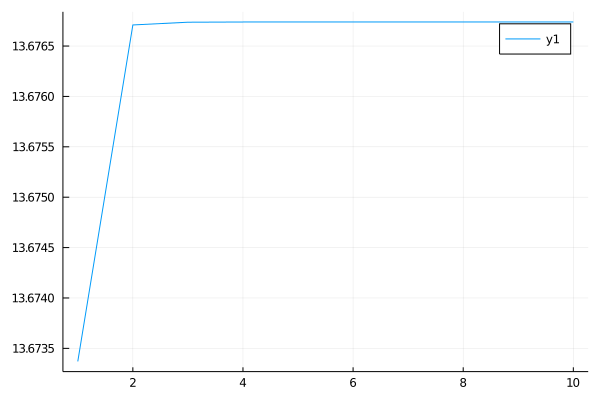

In [26]:
# Initialize with the orthogonal factors from the HOSVD
Ut1 = U1[:,1:2]
Ut2 = U2[:,1:2]
Ut3 = U3[:,1:2]

# Compute an updated matrix factor
function update_U(B, k)
    UU, SS, VV = svd(B)
    return UU[:,1:k], norm(SS[1:k])
end

# Track the norm of the S factor over iterations
Snorm = zeros(10)
Snorm[1] = norm(S[1:2,1:2,1:2])
for k = 2:10
    Ut1, ϕ = update_U(A1 * kron(Ut3, Ut2), 2)
    Ut2, ϕ = update_U(A2 * kron(Ut3, Ut1), 2)
    Ut3, ϕ = update_U(A3 * kron(Ut2, Ut1), 2)
    Snorm[k] = ϕ
end

# Plot the norm of the S matrix
plot(Snorm)

Plotting the differences between $S$ norms at consecutive steps gives us a hint of fast linear convergence.

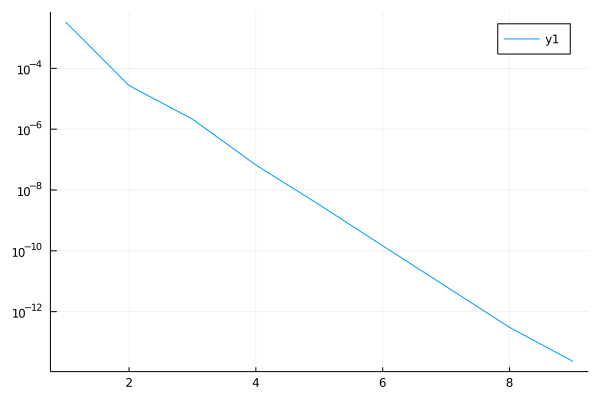

In [27]:
plot(Snorm[2:end]-Snorm[1:end-1], yscale=:log10)

## Alternating least squares for CP

The CP decomposition is a sum-of-rank-one type of decomposition that does not insist on orthonormal factors, i.e. for the third-order case we have
$$
  A = \sum_{j=1}^r \lambda_j F_{:,j} \circ G_{:,j} \circ H_{:,j}.
$$
Here, too, the standard approach involves alternating least squares problems, followed by normalization of the columns:
$$\begin{align*}
  \mbox{minimize } & \|A_{(1)} - \tilde{F} (H \odot G)^T\|^2, & \lambda_{j} F_{:,j} & = \tilde{F}_{:,j} \\
  \mbox{minimize } & \|A_{(2)} - \tilde{G} (H \odot F)^T\|^2, & \lambda_{j} G_{:,j} & = \tilde{G}_{:,j} \\
  \mbox{minimize } & \|A_{(3)} - \tilde{H} (G \odot F)^T\|^2, & \lambda_{j} H_{:,j} & = \tilde{H}_{:,j}
\end{align*}$$
Recall that $\odot$ refers to the Khatri-Rao product, which is composed of Kronecker products of matching columns.  This is therefore a very tall skinny least squares problem.  There is some special structure that one can take advantage of, but we are willing to be lazy and formulate it in the usual way.

We begin with functions to form the Khatri-Rao product of two matrices, to do column normalization, and to form the tensor represented by a given set of scale factors and matrices.

In [28]:
function krprod(B, C)
    mB, nB = size(B)
    mC, nC = size(C)
    BC = zeros(mB*mC, nB)
    for j = 1:nB
        BC[:,j] = kron(B[:,j], C[:,j])
    end
    return BC
end

function colnormalize(Ft)
    mF, nF = size(Ft)
    λs = zeros(nF)
    F = zeros(mF, nF)
    for j = 1:nF
        λs[j] = norm(Ft[:,j])
        F[:,j] = Ft[:,j] / λs[j]
    end
    return F, λs
end

function form_cp(λs, F, G, H)
    A = zeros(size(F)[1], size(G)[1], size(H)[1])
    for p = 1:length(λs)
        for i = 1:size(F)[1]
            for j = 1:size(G)[1]
                for k = 1:size(H)[1]
                    A[i,j,k] += λs[p] * F[i,p] * G[j,p] * H[k,p]
                end
            end
        end
    end
    return A
end

form_cp (generic function with 1 method)

## TODO
### The alternating least squares algorithm (3 points)

Complete the following loop for the alternating least squares algorithm for the CP decomposition, and plot the residual error on a semi-log scale as above.

In [29]:
# Set up a good (but not exact) initial guess
Fc, λsF = colnormalize(F)
Gc, λsG = colnormalize(G)
Hc, λsH = colnormalize(H)
Fc += 0.1 * rand(10,3)
Gc += 0.1 * rand(10,3)
Hc += 0.1 * rand(10,3)
λs = λsF .* λsG .* λsH

resids = zeros(500)
resids[1] = norm(A-form_cp(λs, Fc, Gc, Hc))
for k = 2:500
    # TODO: Fill in with ALS step
    resids[k] = norm(A-form_cp(λs, Fc, Gc, Hc))
end
# TODO: Plot residuals

## TODO
### Khatri-Rao and Gram matrices (3 points)

The Gram matrix that appears in the normal equations for a least squares problem involving a Khatri-Rao product (i.e. minimizing $\|(B \odot C) u - d\|^2$) has a special form:
$$
  (B \odot C)^T (B \odot C) = (B^T B) .* (C^T C)
$$
where $.*$ refers to the Hadamard (elementwise) product.  Explain why this is true.